In [1]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.experimental import optimizers

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [2]:
def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [3]:
class NeuralNetRegression():
  def __init__(self, X, y, layers, rng_key = random.PRNGKey(0)):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.layers = layers

    # Use stax to set up network initialization and evaluation functions
    self.net_init, self.net_apply = MLP(layers)
    
    # Initialize parameters, not committing to a batch shape
    params = self.net_init(rng_key)
                
    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.sgd(1e-4)
    self.opt_state = self.opt_init(params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss = (y - y_pred)**2
    return loss

  def loss(self, params, batch):
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      params = self.get_params(self.opt_state)
      loss_value = self.loss(params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.net_apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

  def compute_activations(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    def MLP_pass(params, inputs):
        H = []
        for W, b in params[:-1]:
              outputs = np.dot(inputs, W) + b
              inputs = np.tanh(outputs)
              H.append(inputs)
        return H
    # Get predictions
    pred_fn = lambda x: MLP_pass(params, x)
    activations = vmap(pred_fn)(X_star)
    return activations

In [4]:
def f(x):
  x1, x2 = x[0], x[1]
  y = np.sqrt(x1**2 + x2**2)
  return y

In [5]:
rng_key = random.PRNGKey(0)

d = 2
lb = -2.0*np.ones(d)
ub = 2.0*np.ones(d)
n = 2000
noise = 0.1

# Create training data
X = lb + (ub-lb)*random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

In [6]:
layers = [2, 32, 32, 32, 32, 1]
model = NeuralNetRegression(X, y, layers)

In [7]:
model.train(num_epochs = 2000, batch_size = 128)

100%|██████████| 2000/2000 [03:38<00:00,  9.17it/s, Loss=0.6182994]


In [10]:
opt_params = model.get_params(model.opt_state)
y_pred = model.predict(opt_params, X_star)

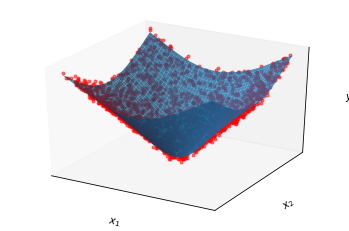

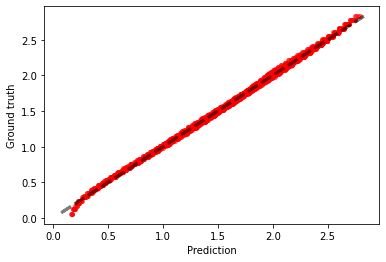

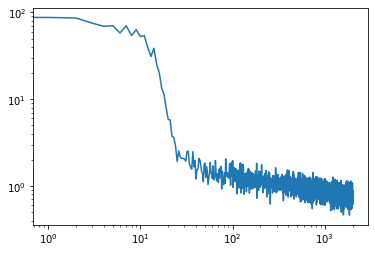

In [11]:
Yplot = griddata(X_star, y_pred.flatten(), (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')

In [13]:
full_batch = model.X, model.y
activations = model.compute_activations(opt_params, X_star)
param_grads = grad(model.loss)(opt_params, full_batch)

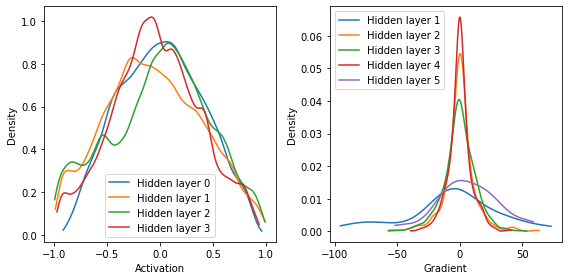

In [21]:
from scipy.stats import kde

def kde1d(x):
  nn = 1000
  xi = np.linspace(x.min(), x.max(), nn)
  k = kde.gaussian_kde(x)
  zi = k(xi)
  return xi,zi

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for i in range(len(activations)):
  x, z = kde1d(activations[i].flatten())
  plt.plot(x, z, label = 'Hidden layer %d' % (i))
plt.legend()
plt.xlabel('Activation')
plt.ylabel('Density')
plt.tight_layout()
plt.subplot(1,2,2)
for i in range(len(param_grads)):
  x, z = kde1d(param_grads[i][0].flatten())
  plt.plot(x, z, label = 'Hidden layer %d' % (i+1))
plt.legend()
plt.xlabel('Gradient')
plt.ylabel('Density')
plt.tight_layout()
